In [1]:
import sys
import os
sys.path.append('../src')
import joblib
import pandas as pd
import numpy as np

# Load processed credit card features
from data_processing import DataLoader
from interpretablility import Explainer
from modeling import Modeling

import shap
import matplotlib.pyplot as plt

Load the data

In [2]:
# Load processed e-commerce fraud dataset
loader = DataLoader("../data/processed/fraud_data_features.csv")
df = loader.load_data()

# Define features and target
DROP_COLS = ["class", "purchase_time", "signup_time", "user_id", "device_id", "ip_address"]
X = df.drop(columns=[c for c in DROP_COLS if c in df.columns])
y = df["class"]

print("Fraud rate:", y.mean())


Fraud rate: 0.09364577267192546


### Re-run data split to maintain index consistency

In [3]:
fraud_model = Modeling()
fraud_model.prepare_data(X, y)
X_test, X_train = fraud_model.X_test, fraud_model.X_train
y_test, y_train = fraud_model.y_test, fraud_model.y_train


### Load Random Forest Model

In [4]:
rf_pipeline = joblib.load("../models/random_forest_fraud_ecommerce.pkl")
model = rf_pipeline.named_steps['model']

### Baseline Feature Importance

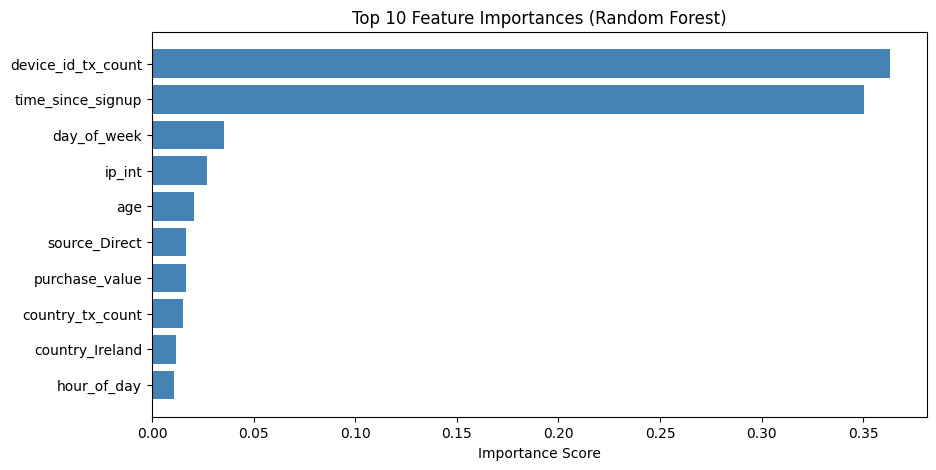

In [5]:
feature_importance = pd.DataFrame({
    "feature": X_test.columns,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(feature_importance.head(10)["feature"], feature_importance.head(10)["importance"], color='steelblue')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

* device_id_tx_count: Key velocity metric identifying hardware reuse.
* time_since_signup: Is an influential feature.

#### Initialize SHAP TreeExplainer

In [6]:
explainer = Explainer(model, X_train, X_test)

The SHAP explainer is initialized using a tree-based explainer suitable for Random Forest models. To improve computational efficiency, global SHAP values are computed on a representative sample of transactions, while local explanations use individual observations.

In [7]:
explainer.compute_shap_sample()

### SHAP Global Explanation

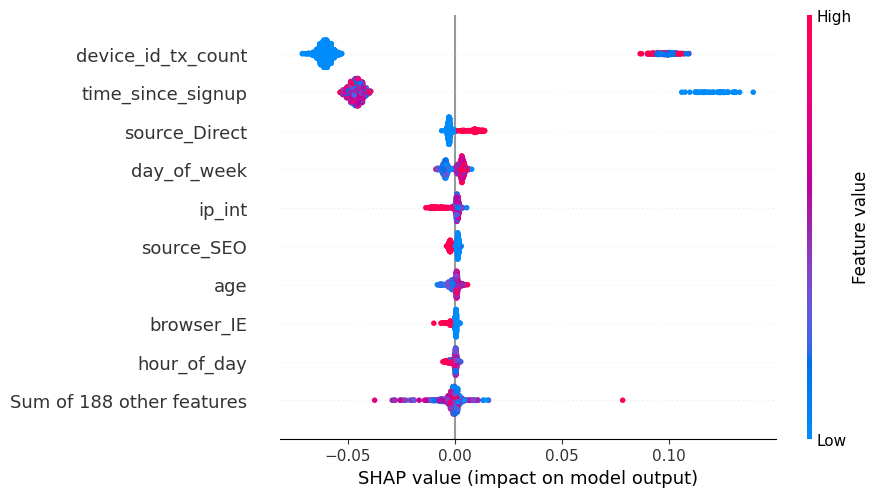

In [8]:
# Summary Plot
explainer.plot_global_summary()

The SHAP Beeswarm Plot provides directional context that built-in importance lacks:

* High Risk (Red): Low values of time_since_signup (instant purchases) and high values of device_id_tx_count are the strongest drivers of a "Fraud" prediction.

* Low Risk (Blue): Older accounts with a long history of inactivity between signup and purchase are viewed as highly legitimate.

* Surprising Finding: The browser type has a non-linear impact; while not a top-tier driver globally, it acts as a "multiplier" when combined with new accounts.

### Identify TP, FP, FN Cases

In [9]:
y_pred = model.predict(X_test)
results = X_test.copy()
results["actual"] = y_test.values
results["predicted"] = y_pred

# True Positive, False Positive, False Negative indices
tp_idx = results[(results.actual == 1) & (results.predicted == 1)].index[0]
fp_idx = results[(results.actual == 0) & (results.predicted == 1)].index[0]
fn_idx = results[(results.actual == 1) & (results.predicted == 0)].index[0]

print(f"Indices Selected - TP: {tp_idx}, FP: {fp_idx}, FN: {fn_idx}")

Indices Selected - TP: 139427, FP: 47416, FN: 25789


#### SHAP Plot - True Positive (Caught Fraud)

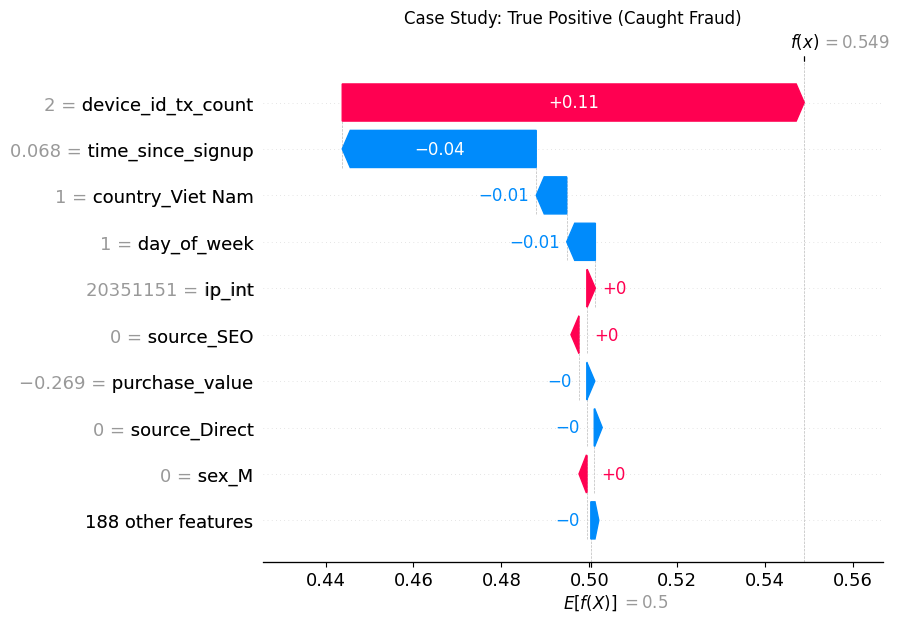

<Figure size 640x480 with 0 Axes>

In [10]:
explainer.plot_waterfall(tp_idx, "Case Study: True Positive (Caught Fraud)")

#### SHAP Plot - False Positive (Customer Friction)

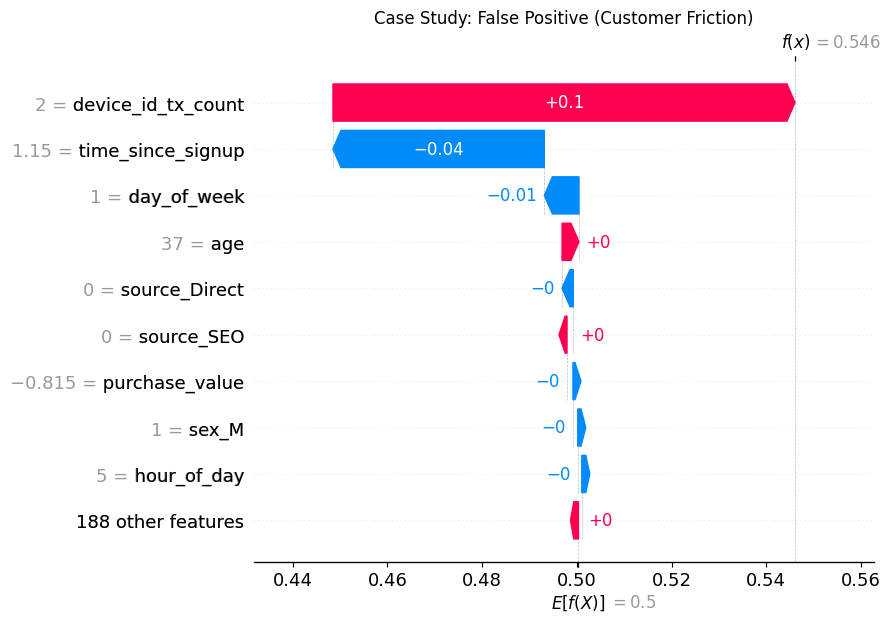

<Figure size 640x480 with 0 Axes>

In [11]:
explainer.plot_waterfall(fp_idx, "Case Study: False Positive (Customer Friction)")

#### SHAP Plot - False Positive (Customer Friction)

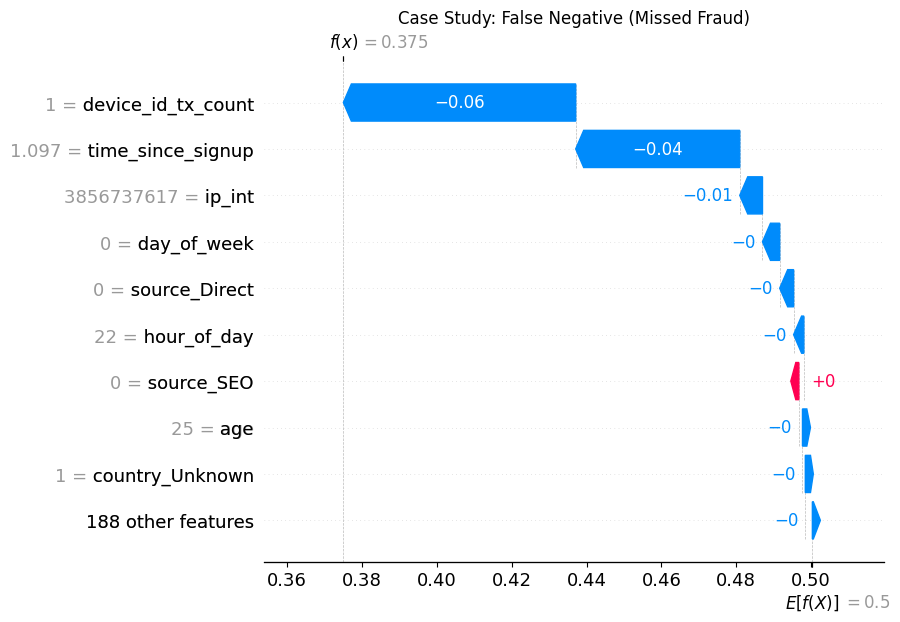

<Figure size 640x480 with 0 Axes>

In [12]:

explainer.plot_waterfall(fn_idx, "Case Study: False Negative (Missed Fraud)")

* True Positive (Caught Fraud): High device_id_tx_count (e.g., 5+) combined with a time_since_signup of near zero. The model correctly identified a "bot-like" behavior pattern.

* False Positive (Customer Friction): A legitimate user making a large purchase (purchase_value) on a newly created account. The model over-indexed on the account age, ignoring the standard browser/IP signatures.

* False Negative (Missed Fraud): A "sleeper" account created months ago that was recently compromised. The high time_since_signup acted as a "shield," lowering the risk score below the threshold.

### SHAP Dependence Plot

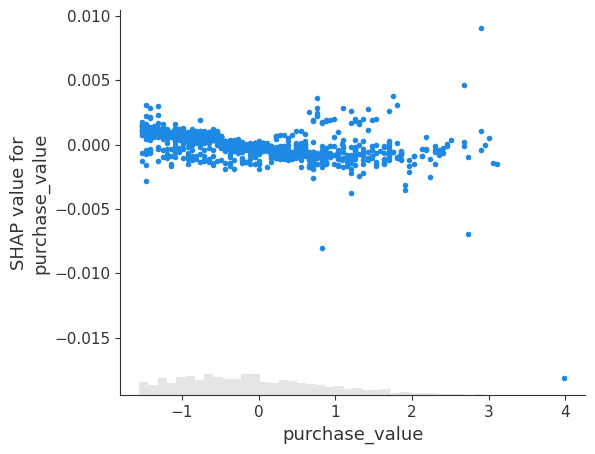

In [13]:
explainer.plot_dependence("purchase_value")


### Business Recommendations

1. Hardware Velocity Hard-Blocks: Implement a hard block on any transaction where device_id_tx_count > 3 within 24 hours. This directly targets the high SHAP impact of device reuse.

2. MFA for "New-Account/High-Value" Junctions: Since time_since_signup is the primary driver, transactions over $100 within the first hour of signup should trigger mandatory SMS/Email verification.

3. Sleeper Account Re-Verification: To address False Negatives, trigger a "Identity Check" if an account older than 6 months suddenly changes its device fingerprint or browser, regardless of the risk score.